In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pyfits as pf
import numpy as np
import cosmolopy.distance as cd
from astropy.stats import median_absolute_deviation
%pylab inline 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['axes.labelsize'] = 25
from matplotlib.colors import LogNorm
from scipy import stats
from astropy.stats import median_absolute_deviation

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import gridspec
mpl.rcParams['axes.titlesize'] = 25
import pyccl as ccl

In [3]:
import scipy.optimize as op

In [607]:
sample = h5py.File("../lrg_lum_dr4_v3.h5" , "r")
spec_calib = h5py.File("../specLRG_cut_lmin_0.5_nbar_0.001_auto_vcosmo_v2_total.h5")
specall = h5py.File("/net/vuntus/data2/vakili/nired/dr4/specall_v2.h5")

In [608]:
mr_auto = sample['mr'][:]
mask = (sample['zlrg'][:]<0.6)&(sample['star_mask'][:]==0)
bad_mask = (sample['zlrg'][:]<0.6)&(sample['star_mask'][:]==1)
mr_auto.max()

25.135174

/software/local/lib64/python2.7/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


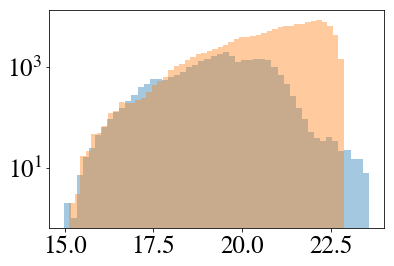

In [15]:
sns.distplot(spec_calib["mr"][:] ,norm_hist= False, kde = False)
#sns.distplot(specall["mr"][:] ,norm_hist= False, kde = False)
sns.distplot(sample["mr_auto"][:],norm_hist= False, kde = False)
plt.yscale("log")

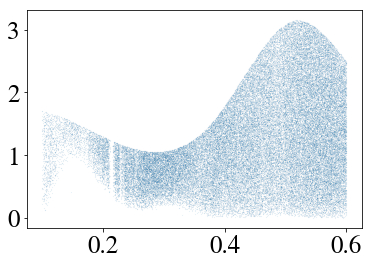

In [7]:
#sns.distplot(sample["chired"][:],norm_hist= False, kde = False)
#plt.yscale("log")
plt.scatter(sample["zlrg"][mask], sample["chired"][mask], s= 0.001)

In [10]:
sample.keys()

[u'DEC',
 u'ID',
 u'RA',
 u'chired',
 u'color_errs',
 u'colors',
 u'kids_mask',
 u'lratio',
 u'mg',
 u'mh',
 u'mi',
 u'mj',
 u'mk',
 u'mr',
 u'mr_auto',
 u'mu',
 u'my',
 u'mz',
 u'star_mask',
 u'tile',
 u'zlrg']

In [11]:
specall.keys()

[u'DEC',
 u'ID',
 u'RA',
 u'color_errs',
 u'colors',
 u'lim_g',
 u'lim_i',
 u'lim_r',
 u'lim_u',
 u'lim_z',
 u'mi',
 u'mi_err',
 u'mr',
 u'mr_err',
 u'mz',
 u'mz_err',
 u'redshift',
 u'zb']

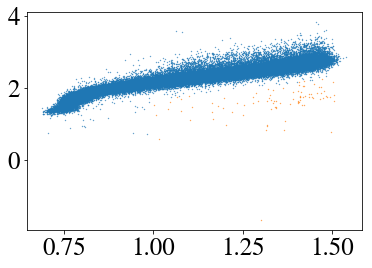

In [609]:
plt.scatter( sample['mr'][:][mask] - sample['mz'][:][mask], sample['mr'][:][mask] - sample['mk'][:][mask],s = 0.1)
plt.scatter( sample['mr'][:][bad_mask] - sample['mz'][:][bad_mask], sample['mr'][:][bad_mask] - sample['mk'][:][bad_mask],s = 0.1)

In [612]:
def photoz_test(lrg_type):
    if lrg_type == "dense":
        
        sample = h5py.File("../lrg_dense_dr4_v3.h5" , "r")
        spec_calib = h5py.File("../specLRG_cut_lmin_0.5_nbar_0.001_auto_vcosmo_v2_total.h5")
    
    elif lrg_type == "lum":
        
        sample = h5py.File("../lrg_lum_dr4_v3.h5" , "r")
        spec_calib = h5py.File("../specLRG_cut_lmin_1.0_nbar_0.00025_auto_vcosmo_v2_new.h5")
    
    specall = h5py.File("/net/vuntus/data2/vakili/nired/dr4/specall_v2.h5")
    
    print sample
    mask = np.where((sample['star_mask'][:] == 0)&(sample['kids_mask'][:] == 0)
                    &(np.isfinite(sample['mk'][:])==True)&(sample['zlrg'][:] < 0.75))[0]
    lrg_id = sample['ID'][:][mask]
    lrg_color = sample['colors'][:][mask]
    lrg_lr = sample['lratio'][:][mask]
    lrg_zp = sample['zlrg'][:][mask]
    lrg_mr = sample['mr_auto'][:][mask]
    
    spec_id = specall['ID'][:]
    y = []
    for x in spec_id:
        y.append(x.split(' ')[0]+' '+x.split(' ')[1])
    spec_id = np.array(y)

    
    spec_zp = specall['redshift'][:]
    
    calib_mask = np.where((spec_calib['RA'][:]>148)&(spec_calib['RA'][:]<152)&(spec_calib['DEC'][:]>1)&(spec_calib['DEC'][:]<3))[0]
    calib_id = spec_calib['ID'][:][calib_mask]
    calib_mr = spec_calib['mr'][:][calib_mask]
    calib_zs = spec_calib['zspec'][:][calib_mask]
    calib_zp = spec_calib['zred'][:][calib_mask]
    calib_lr = spec_calib['lratio'][:][calib_mask]
    calib_colors = spec_calib['color'][:][calib_mask]
    

    
    mask_one = np.where((np.in1d(lrg_id, spec_id)==True))[0]
    mask_two = np.where((np.in1d(spec_id, lrg_id[mask_one])==True))[0]
    arg_one = np.argsort(lrg_id[mask_one], kind = 'stable')
    arg_two = np.argsort(spec_id[mask_two], kind = 'stable')

    color_len =  len(calib_colors) + len(lrg_color[mask_one][arg_one])
    union_colors = np.zeros((color_len, 4))
    union_colors[:len(calib_colors), :] = calib_colors
    union_colors[len(calib_colors):, :] = lrg_color[mask_one][arg_one]
    
    spec = {'mr' : np.append(calib_mr, lrg_mr[mask_one][arg_one]),
            'zspec': np.append(calib_zs, spec_zp[mask_two][arg_two]),
            'zred': np.append(calib_zp, lrg_zp[mask_one][arg_one]), 
            'colors': union_colors}
    
    #################################################################
    
    plt.figure(figsize=(11,10))

    hist = plt.hist2d(spec['zred'], spec['zspec'], norm = LogNorm(), bins = 150, vmin = 1)
    plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), "k--", linewidth = 1)
    plt.colorbar()
    plt.xlim((0.01,0.89))
    plt.ylim((0.01,0.89))
    plt.xlabel(r"$z_{\rm red}$")
    plt.ylabel(r"$z_{\rm spec}$")
    plt.show()
    plt.close()
    #################################################################33
    plt.figure(figsize=(10,10))
 
    y2 = (spec['zred'] - spec['zspec'])/(1+spec['zred'])
    z2 = spec['zred'] - spec['zspec']
    x2 = spec['zred']
    bins = np.linspace(0.11, 0.79, 10)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                            y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, 
             label = "scatter", color =  'red')

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)
    
    bin_means_errs, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             np.abs(z2), 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)
    
    plt.errorbar(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o",
             label = "bias", color =  '#1F77B4')

    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    plt.axhline(1.4826*np.mean(np.abs(bin_std)),
             linestyle="dashed", color = 'C4', label = "mean scatter")

    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{\rm red}$")
    plt.ylabel("scatter or bias")
    plt.legend(loc = 'upper left' , fontsize = 30)
    plt.xlim([0.05,0.85])
    plt.ylim([-0.015,0.03])
    
    plt.show()
    plt.close()
    
    #################################################################33
    plt.figure(figsize=(10,10))
 
    y2 = (spec['zred'] - spec['zspec'])/(1+spec['zred'])
    z2 = spec['zred'] - spec['zspec']
    x2 = spec['mr']
    bins = np.linspace(16, 22.7, 10)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                            y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, 
             label = "scatter", color =  'red')

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)
    
    bin_means_errs, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='std', 
                                                             bins=bins)
    print bin_means_errs
    
    plt.errorbar(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o",
             label = "bias", color =  '#1F77B4')
    
    plt.axhline(0,
             linestyle="dashed", color = 'k')

    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    plt.axhline(1.4826*np.mean(np.abs(bin_std)),
             linestyle="dashed", color = 'C4', label = "mean scatter")

    plt.xlabel(r"$m_{\rm r, AUTO}$")
    plt.ylabel("scatter or bias")
    plt.legend(loc = 'upper left' , fontsize = 30)
    plt.xlim([16, 23])
    plt.ylim([-0.015,0.04])
    
    plt.show()
    plt.close()
    
    sample.close()
    spec_calib.close()
    specall.close()
    return spec

<HDF5 file "lrg_lum_dr4_v3.h5" (mode r)>


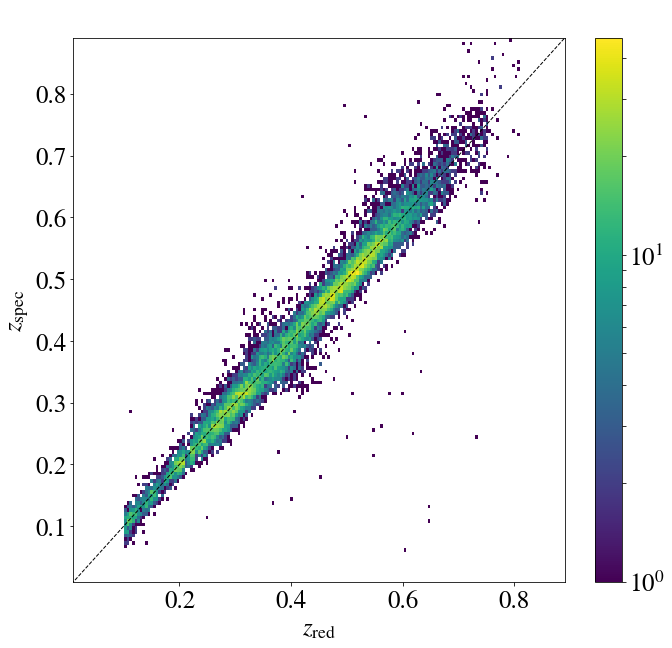

mean bias 0.0007928591220348274
mean scatter 0.01529948546464579


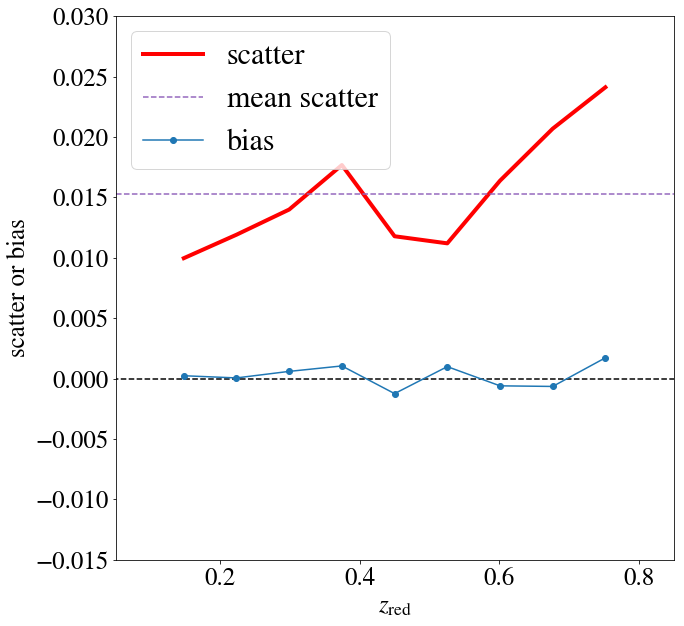

[0.01188663 0.01466349 0.0155615  0.02424055 0.02576325 0.02468715
 0.03244658 0.05972459 0.06372024]
mean bias 0.002334277174700392
mean scatter 0.015393271869488712


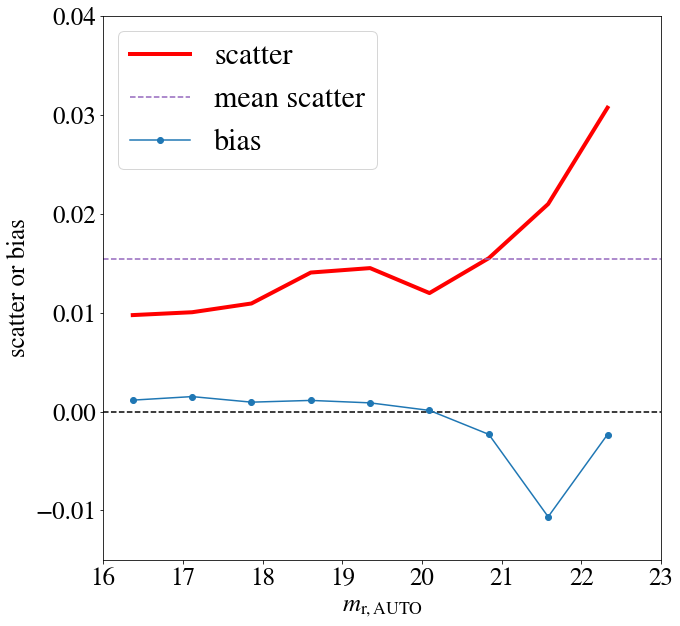

In [613]:
spec = photoz_test("lum")

In [614]:
def nstar_test():
    
        
    sample = h5py.File("../lrg_dense_dr4_v3.h5" , "r")
    star_mask = np.where((sample['star_mask'][:] == 1)&(sample['kids_mask'][:] == 0)
                    &(np.isfinite(sample['mk'][:])==True))[0]
    lrg_mask = np.where((sample['star_mask'][:] == 0)&(sample['kids_mask'][:] == 0)
                    &(np.isfinite(sample['mk'][:])==True))[0]
    
    star_z = sample["zlrg"][:][star_mask]
    red_z = sample["zlrg"][:][lrg_mask]
    
    star_hist, bin_edges = np.histogram(star_z, bins = np.linspace(0,0.8, 200), density=False)
    red_hist, bin_edges = np.histogram(red_z, bins = np.linspace(0,0.8, 200), density=False)
    bin_centers = .5*(bin_edges[1:] + bin_edges[:-1])
    sample.close()
    
    plt.figure(figsize = (10,10))
    plt.plot(bin_centers, 1. - 1.*star_hist/red_hist, color = "C2", 
             linewidth = 4, linestyle = "dashed", label = "dense red-sequence sample")
    
    sample = h5py.File("../lrg_lum_dr4_v3.h5" , "r")
    star_mask = np.where((sample['star_mask'][:] == 1)&(sample['kids_mask'][:] == 0)
                    &(np.isfinite(sample['mk'][:])==True))[0]
    lrg_mask = np.where((sample['star_mask'][:] == 0)&(sample['kids_mask'][:] == 0)
                    &(np.isfinite(sample['mk'][:])==True))[0]
    
    star_z = sample["zlrg"][:][star_mask]
    red_z = sample["zlrg"][:][lrg_mask]
    
    star_hist, bin_edges = np.histogram(star_z, bins = np.linspace(0,0.8, 200), density=False)
    red_hist, bin_edges = np.histogram(red_z, bins = np.linspace(0,0.8, 200), density=False)
    bin_centers = .5*(bin_edges[1:] + bin_edges[:-1])
    sample.close()
    
    plt.plot(bin_centers, 1. - star_hist*1./red_hist , color = "C1", 
             linewidth = 4, linestyle = "dashed", label = "luminous red-sequence sample")
    plt.axhline(1.,
             linestyle="dashed", color = 'k')
    plt.xlabel(r"$z_{\rm red}$")
    plt.ylabel("Purity (1 - stellar contamination fraction)")
    plt.legend(fontsize = 28)
    plt.xlim([0.05,0.85])
    #plt.ylim([0,1.05])
    
    plt.show()
    plt.tight_layout()
    plt.close()
    
    return None

/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide
/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide


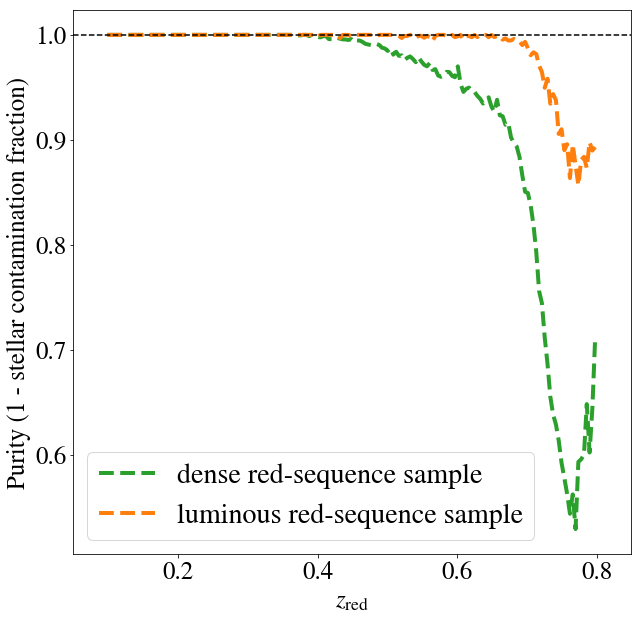

In [615]:
nstar_test()

In [691]:
lumsig = h5py.File("../red_sigmaz_lum.h5", 'r')
lumsig.close()

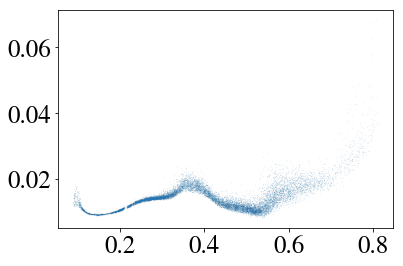

In [286]:
#sns.distplot(CubicSpline(bins , r)(zred) * sigma / (1+zred))
plt.scatter(zred, CubicSpline(bins , r)(zred) * sigma / (1+zred) , s = 0.001)

#print np.mean(CubicSpline(bins , r)(zred) * sigma / (1+zred))

In [737]:
import scipy.optimize as op
from scipy.interpolate import CubicSpline
#redsig = h5py.File("../red_sigmaz_speclum.h5")
#red = h5py.File("../specLRG_cut_lmin_1.0_nbar_0.00025_auto_vcosmo_v2_new.h5")

def sigma_correction(lrg_type):

    if lrg_type == 'dense':
        
        redsig = h5py.File("../red_sigmaz_specdense.h5")
        red = h5py.File("../specLRG_cut_lmin_0.5_nbar_0.001_auto_vcosmo_v2_total.h5")
    
    if lrg_type == 'lum':
        
        redsig = h5py.File("../red_sigmaz_speclum.h5")
        red = h5py.File("../specLRG_cut_lmin_1.0_nbar_0.00025_auto_vcosmo_v2_new.h5")

    sigma = redsig["sigmaz"][:]
    zred = red["zred"][:]
    zspec = red["zspec"][:]

    bins = np.linspace(0.1, 0.8, 20)
    r_init = np.ones_like(bins)

    def ab_lnlike(theta):

        rsigma0 = CubicSpline(bins , theta)(zred) * sigma
        smad  = 1.4826 * np.abs(zred - zspec)
        E = np.sum(np.abs(smad - rsigma0))

        return E

    nll = lambda *args: ab_lnlike(*args)
    result = op.minimize(nll, [r_init], args=())
    r = result["x"]
    print r


    red.close()
    redsig.close()
    
    return bins, r

/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


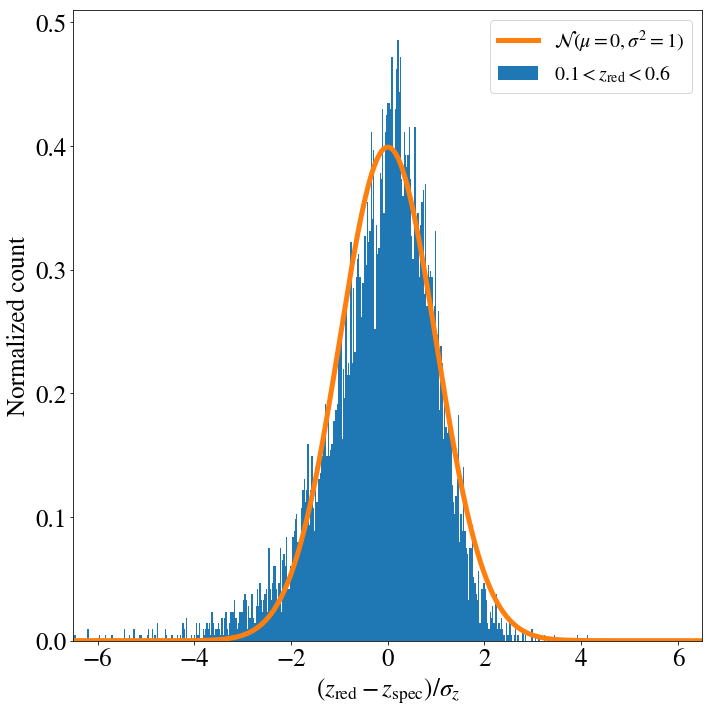

In [359]:
from scipy.stats import norm
rv1 = norm(loc = 0., scale = 1.0)
a = np.linspace(-10,10, 1000)

plt.figure(figsize = (10,10))

var = (zred - zspec)/(CubicSpline(bins , r)(zred) * sigma)
#a = np.random.normal(loc = 0 , scale = 1, size = 1000000)
xx = plt.hist(var[(zred>.15)&(zred<0.3)], normed=True, bins = 1000, label = r"$0.1<z_{\rm red}<0.6$")

plt.plot(a, rv1.pdf(a), linewidth = 5, label = r"$\mathcal{N}(\mu = 0 , \sigma^{2} =1)$" )

#sns.distplot(a, kde = True, hist=False, kde_kws={"linewidth": 6, 
#                                                 "alpha" : 1.0, "label":r"$\mathcal{N}(\mu = 0 , \sigma^{2} =1)$"})

plt.xlabel(r"$(z_{\rm red} - z_{\rm spec})/\sigma_z$")
plt.ylabel("Normalized count")
plt.legend(fontsize = 20)
plt.xlim(-6.5,6.5)
plt.tight_layout()

In [363]:
import math

def divisorGenerator(n):
    large_divisors = []
    for i in xrange(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

print list(divisorGenerator(531672))

[1, 2, 3, 4, 6, 8, 12, 24, 22153, 44306, 66459, 88612, 132918, 177224, 265836, 531672]


In [364]:
531672/24

22153

In [368]:
x = np.array([1.,2.001])

In [369]:
x.astype(int)

array([1, 2])

In [13]:
def load_shear(lrg_type, lens_bin , source_bin):
    
    if lens_bin == 0:
        zlmin, zlmax = 0.15, 0.3
    if lens_bin == 1:
        zlmin, zlmax = 0.3, 0.45
    if lens_bin == 2:
        zlmin, zlmax = 0.45, 0.6
    if lens_bin == 3:
        zlmin, zlmax = 0.6, 0.8
        
    if source_bin == 0:
        zsmin, zsmax = 0.1, 0.3
    if source_bin == 1:
        zsmin, zsmax = 0.3, 0.5
    if source_bin == 2:
        zsmin, zsmax = 0.5, 0.7
    if source_bin == 3:
        zsmin, zsmax = 0.7, 0.9
    if source_bin == 4:
        zsmin, zsmax = 0.9, 1.2
    prefix = 0 
    if lrg_type == "dense":
        prefix = "xshear/files/tshear"
        
    if lrg_type == "lum":
        prefix = "xshear/files/tshear_lum" 
    #print prefix
    
    if (lrg_type == "dense")&(lens_bin == 0)&(source_bin == 3):
        fname = "xshear/files/exception.h5"
    else:
        fname = prefix+"_zl_"+str(zlmin)+"_"+str(zlmax)+"_"+"zs_"+str(zsmin)+"_"+str(zsmax)+".h5"
    
    f = h5py.File(fname, "r")
    fctr = (100 - 1.)/(100. - 20 - 1.)
    r, xi, xierr = f['r'][:], f['xi_t'][:] - f['xi_tr'][:], np.diag(f['cov'][:]/fctr)**.5
    f.close()
    
    return r, xi, xierr, zlmin, zlmax, zsmin, zsmax, lrg_type
    
   

    
    

In [14]:
def plot_shear(lrg_type):
    
    fig = plt.figure(1, figsize=(16,16))
    
    gs = gridspec.GridSpec(4,5)
    titx = [r"$0.1<z_s<0.3$", r"$0.3<z_s<0.5$", r"$0.5<z_s<0.7$", r"$0.7<z_s<0.9$", r"$0.9<z_s<1.2$"]
    tity = [r"$0.15<z_l<0.3$", r"$0.3<z_l<0.45$", r"$0.45<z_l<0.6$", r"$0.6<z_l<0.8$"]
    for i in range(4):
        for j in range(5):   
        
            ax = plt.subplot(gs[i,j])
    
          #print i
            r, xi, xierr, zlmin, zlmax, zsmin, zsmax, lrg_type = load_shear(lrg_type= lrg_type, lens_bin=i , source_bin=j)
            print r
            pos_mask = np.where(xi>0)[0]
            neg_mask = np.where(xi<0)[0]
            ax.errorbar(r[pos_mask] , xi[pos_mask] , yerr=xierr[pos_mask] , fmt="o", 
                        color='C'+str(j), markersize=5, lw=0, capsize=3, elinewidth=1.5)
            ax.errorbar(r[neg_mask]  , -1*xi[neg_mask], yerr=xierr[neg_mask], fmt="o", mfc='white', 
                        color='C'+str(j), markersize=5, 
                        lw=0, capsize=3, elinewidth=1.5)
            if j == 0: 
                ax.set_ylabel(r'$\gamma_t \; (\theta)$')
            if i == 3: 
                ax.set_xlabel(r'$\theta \; [\mathrm{arcmin}]$')
 
            ax.set_xscale('log')
            ax.set_yscale('log')        
            ax.set_xlim([.2, 200.])
            ax.set_ylim([5e-6, .04])  
            if j != 0: 
                ax.set_yticklabels([])
                ax.set_yticks([]) 
            if i != 3:
                ax.set_xticklabels([]) 

            if i == 0:
                ax.set_title(titx[j])

            ax.yaxis.set_label_position("right")
            ax.set_ylabel(tity[i])   
                
    fig.subplots_adjust(wspace=0.0, hspace=0.0)       

[ 0.57823319  0.75407727  0.98242993  1.28121465  1.66945839  2.17647201
  2.83591806  3.69742492  4.8178918   6.27899923  8.1859223  10.66950948
 13.90677097 18.12520896 23.62151693 30.78074023 40.1109138  52.2697458
 68.11811034 88.76565384]
[ 0.57820735  0.75421128  0.98296136  1.28077392  1.6693408   2.1758725
  2.83642089  3.69705264  4.81889333  6.27928946  8.18774295 10.67106537
 13.90760878 18.12498912 23.61981431 30.78204948 40.11677609 52.27120129
 68.12545613 88.76747392]
[ 0.5790735   0.75459626  0.98341617  1.28152764  1.66982989  2.17679659
  2.83742387  3.69735367  4.81828574  6.28121467  8.18747951 10.67024844
 13.90829982 18.12586754 23.62006218 30.7811937  40.11393191 52.27025152
 68.12747725 88.77100682]
[ 0.57924283  0.75437627  0.98335251  1.28154889  1.67063745  2.17763265
  2.83746437  3.69735264  4.81973484  6.28098648  8.1878862  10.67080787
 13.90868181 18.12641067 23.62064708 30.78408617 40.11734046 52.27177717
 68.12448149 88.7711842 ]
[ 0.5792401   0.754721

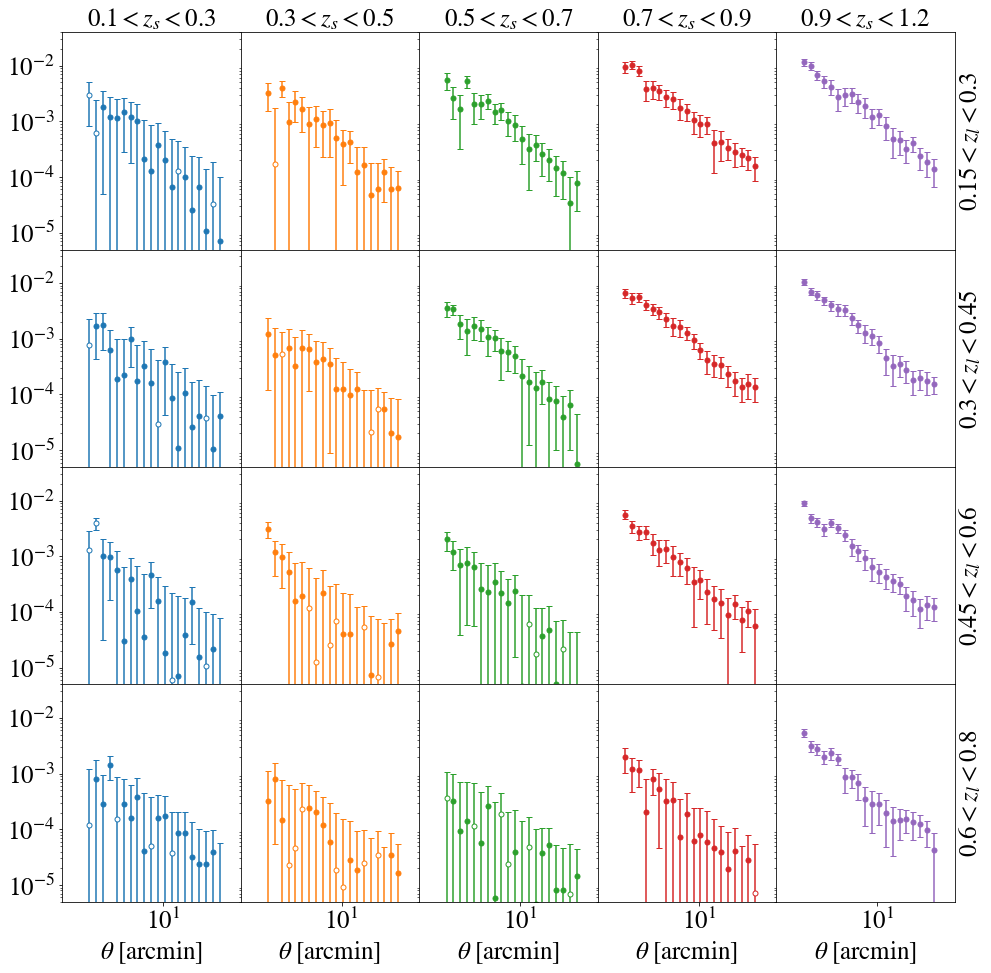

In [15]:
plot_shear(lrg_type = "dense")

[ 0.57772944  0.75241095  0.98220203  1.28064307  1.66878939  2.17748239
  2.8364327   3.69720352  4.81672343  6.2772196   8.18701657 10.66971205
 13.90857534 18.12537687 23.62088277 30.77810407 40.10729952 52.26440581
 68.11678921 88.76919655]
[ 0.57734095  0.75338549  0.98225037  1.27976052  1.66840608  2.17657059
  2.83744048  3.69724678  4.81924395  6.278468    8.18893151 10.67071388
 13.90773493 18.12350452 23.62007802 30.78218803 40.10672041 52.26787548
 68.12980814 88.76868917]
[ 0.57885615  0.75531867  0.98274522  1.28118598  1.66995149  2.17710471
  2.83657434  3.69792227  4.81767505  6.28135382  8.18802426 10.669918
 13.90921942 18.1266729  23.61967362 30.78254964 40.11315529 52.26792495
 68.12499434 88.76849872]
[ 0.57994388  0.754878    0.98313611  1.28124926  1.67088118  2.17657427
  2.83807682  3.69717543  4.8193751   6.28134726  8.18802641 10.67065825
 13.90792433 18.12743612 23.62367587 30.78213203 40.11187243 52.26853534
 68.12420493 88.772608  ]
[ 0.57962521  0.753815

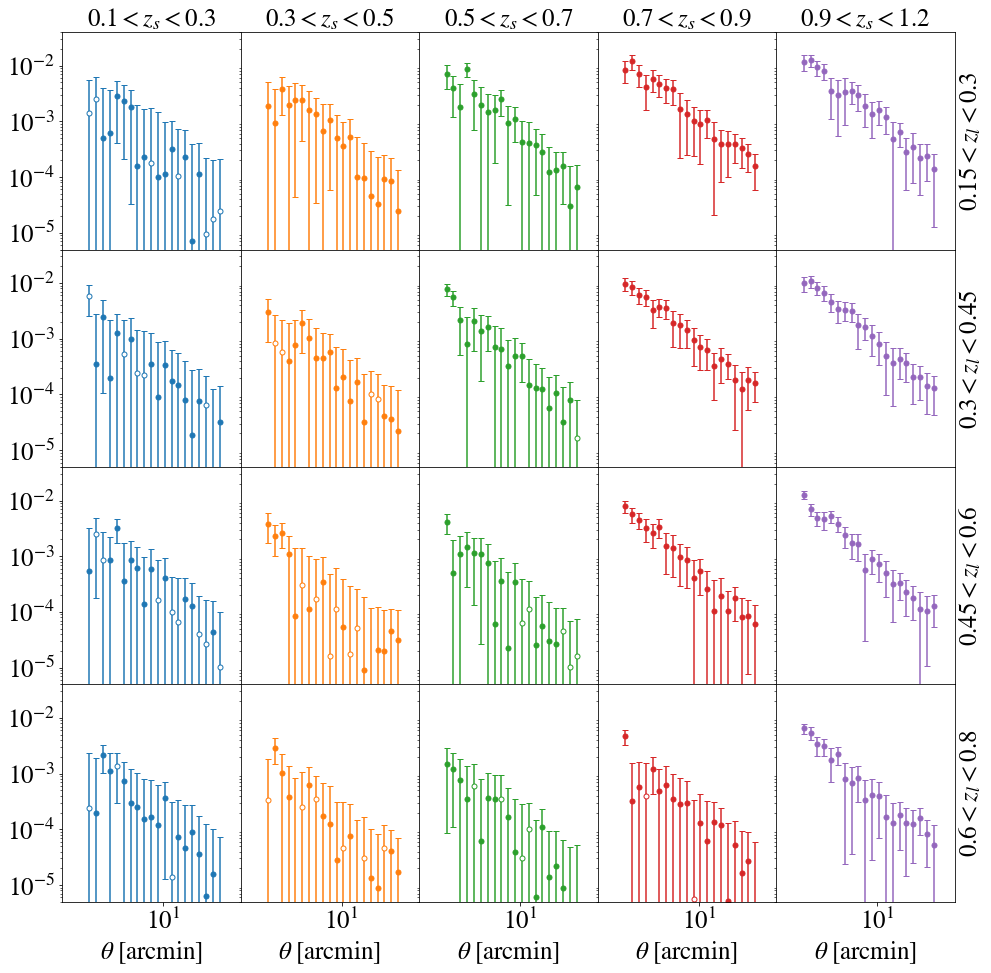

In [16]:
plot_shear(lrg_type = "lum")

In [147]:
def nofz(lrg_type, lens_bin):
    
    if lens_bin == 0:
        zlmin, zlmax = 0.15, 0.3
    if lens_bin == 1:
        zlmin, zlmax = 0.3, 0.45
    if lens_bin == 2:
        zlmin, zlmax = 0.45, 0.6
    if lens_bin == 3:
        zlmin, zlmax = 0.6, 0.8
        
    if lrg_type == "lum":
        
        fname = "../red_sigmaz_lum_new.h5"
        gname = '../lrg_lum_dr4.h5'
        
    if lrg_type == "dense":
        
        fname = "../red_sigmaz_dense.h5"
        gname = '../lrg_dense_dr4.h5'
        
    f = h5py.File(fname, 'r')
    g = h5py.File(gname, 'r')
    
    fsigma = f['sigmaz'][:]
    fids = f['ID'][:]
    gids = g['ID'][:]
    gz = g['zlrg'][:]
    gkids = g['kids_mask'][:]
    gstars = g['star_mask'][:]
    
    mask = np.where((gkids == 0)&(gstars == 0)&(gz>zlmin)&(gz<zlmax))[0]
    
    zred, sred = gz[mask], fsigma[mask]
    
    
    
    f.close()
    g.close()
    
    bins, r = sigma_correction(lrg_type)
    sred =  CubicSpline(bins , r)(zred) * sred
    
    zz = np.linspace(0,1,1000)
    nz = np.zeros_like(zz)
    for i in xrange(len(sred)):
        nz += norm(loc= zred[i], scale=sred[i]).pdf(zz)  
    
    
    return zz, nz 

In [763]:
def nz_saver(lrg_type):
    
    nzs = []
    for i in range(4):
        zz, nz = nofz(lrg_type, i)
        nzs.append(nz)
    nzs = np.array(nzs).T
    print nzs.shape
    #print nzs
    
    ng = nzs.shape[0]
    
    sample_file = h5py.File("nzstack_"+lrg_type+".h5", "w")  #place-holder for the redsq value-added catalog

    sample_file.create_dataset("z", (ng, ), data = zz)
    sample_file.create_dataset("nz", (ng, 4), data = nzs)
    
    sample_file.close()
    
    return zz, nzs

def nz_saver_dense(lrg_type):
    
    nzs = []
    for i in range(3):
        zz, nz = nofz(lrg_type, i)
        nzs.append(nz)
    nzs = np.array(nzs).T
    ng = nzs.shape[0]

    sample_file = h5py.File("nzstack_"+lrg_type+".h5", "w")  #place-holder for the redsq value-added catalog

    sample_file.create_dataset("z", (ng, ), data = zz)
    sample_file.create_dataset("nz", (ng, 3), data = nzs)
    
    sample_file.close()
    
    return zz, nzs

In [764]:
nz_saver('lum')

[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
(1000, 4)


(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [765]:
nz_saver_dense('dense')

[0.96199428 1.42852979 1.3376961  1.36618887 1.72155384 1.73220561
 1.70847997 1.86164935 1.48370118 1.60809887 1.31299387 1.39974151
 1.06742694 1.05666303 1.11802122 1.23789937 1.37900471 1.81135669
 2.88212728 3.96139531]
[0.96199428 1.42852979 1.3376961  1.36618887 1.72155384 1.73220561
 1.70847997 1.86164935 1.48370118 1.60809887 1.31299387 1.39974151
 1.06742694 1.05666303 1.11802122 1.23789937 1.37900471 1.81135669
 2.88212728 3.96139531]
[0.96199428 1.42852979 1.3376961  1.36618887 1.72155384 1.73220561
 1.70847997 1.86164935 1.48370118 1.60809887 1.31299387 1.39974151
 1.06742694 1.05666303 1.11802122 1.23789937 1.37900471 1.81135669
 2.88212728 3.96139531]


(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [722]:
xdgmm = XDGMM(10).fit(z.reshape(z.shape[0], 1), snew.reshape(snew.shape[0], 1, 1)**.5)
xdgmm.mu, xdgmm.V**.5
scales = xdgmm.V.reshape(10,)**.5
mus = xdgmm.mu
alphas = xdgmm.alpha
rv1 = norm(loc = 0., scale = 1.0)
a = np.linspace(0,0.8, 1000)

plt.figure(figsize = (10,10))


ya = alphas[0]*norm(loc= mus[0], scale=scales[0]).pdf(a)

for i in range(1,10):
    ya += alphas[i]*norm(loc= mus[i], scale=scales[i]).pdf(a) 

plt.plot(a, ya, 
         linewidth = 5)


plt.xlabel(r"$(z_{\rm red} - z_{\rm spec})/\sigma_z$")
plt.ylabel("Normalized count")
plt.legend(fontsize = 20)
plt.xlim(0,0.6)
plt.tight_layout()

[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]
[1.10432219 1.25728092 1.16283558 1.1566647  1.52513022 1.58649599
 1.63112078 1.95836782 1.44507841 1.51482387 1.26599528 1.42061872
 1.05097711 1.11759008 1.09982809 1.14524177 1.38487473 1.55608052
 2.56652006 3.315142  ]


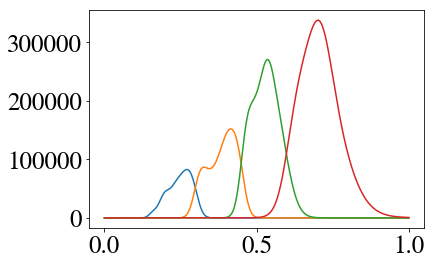

In [746]:
for i in range(4):
    zz, nz = nofz('lum', i)
    plt.plot(zz,nz)

In [820]:
def nz_plotter(lrg_type):
    
    labels = [r"$0.15<z_{\rm red}<0.3$", r"$0.3<z_{\rm red}<0.45$", r"$0.45<z_{\rm red}<0.6$", r"$0.6<z_{\rm red}<0.8$"]
    
    if lrg_type == "lum":
        
        nzfile = h5py.File("nz_lum.h5", 'r')
        
    if lrg_type == "dense":
        
        nzfile = h5py.File("nzstack_dense.h5", 'r')
    
    zs = nzfile["z"][:]
    nzs = nzfile["nz"][:]
    
    n_z , n_tom = nzs.shape
    
    fig = plt.figure(1, figsize=(10,10))
    
    for i in range(n_tom):
        
        plt.plot(zs, nzs[:,i] * 10 ** -6, linestyle = "dashed", linewidth = 3, label = labels[i])
    plt.axhline(0, color = "k", linewidth = 4)
    plt.xlabel(r"$z_{\rm red}$")
    plt.ylabel(r"$10^{-6} \; \times \; n(z_{\rm red})$")
    if lrg_type == 'lum':
        plt.ylim(0, 0.4)
        plt.xlim(0.1,1.01)
        plt.title(r"$L>L_{\star}$")
    if lrg_type == 'dense':
        plt.ylim(0, 1.0)
        plt.xlim(0.1,0.75) 
        plt.title(r"$L>0.5L_{\star}$")
    plt.legend(fontsize = 25)
    plt.tight_layout()
    
    return None
    
        

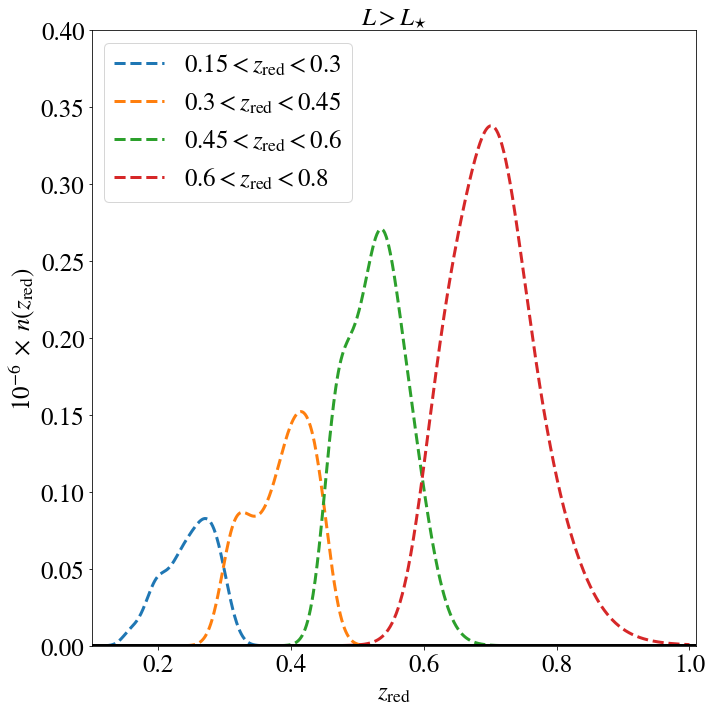

In [821]:
nz_plotter("lum")

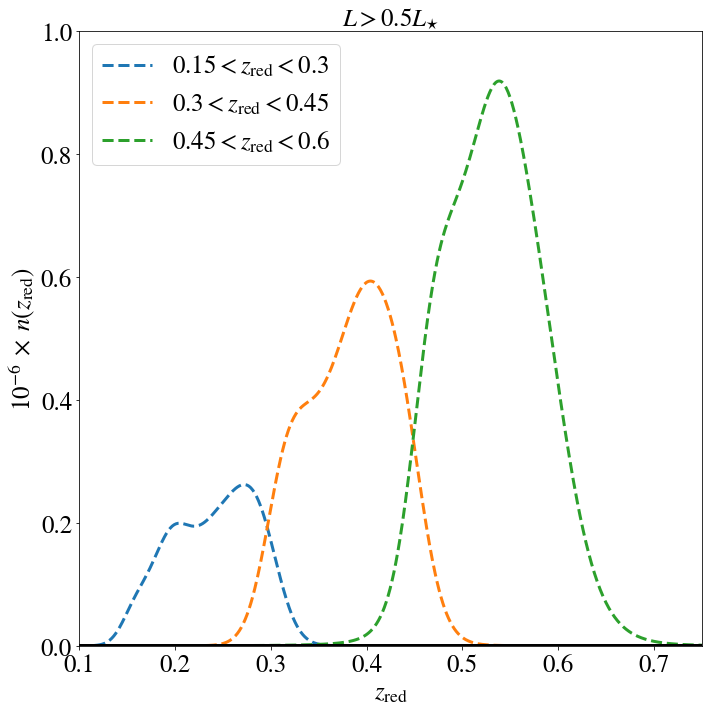

In [822]:
nz_plotter("dense")

In [6]:
def nz_source_plotter():
    
    labels = [r"$0.1<z_s<0.3$", r"$0.3<z_s<0.5$", r"$0.5<z_s<0.7$", r"$0.7<z_s<0.9$", r"$0.9<z_s<1.2$"]
    
    nz0 = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB01t03_blindB_Nz.asc")
    nz1 = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB03t05_blindB_Nz.asc")
    nz2 = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB05t07_blindB_Nz.asc")
    nz3 = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB07t09_blindB_Nz.asc")
    nz4 = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB09t12_blindB_Nz.asc")    
    
    
    fig = plt.figure(1, figsize=(10,10))
    
    plt.plot(nz0[:,0], nz0[:,1], linestyle = "solid", linewidth = 3, label = labels[0])
    plt.plot(nz1[:,0], nz1[:,1], linestyle = "solid", linewidth = 3, label = labels[1])
    plt.plot(nz2[:,0], nz2[:,1], linestyle = "solid", linewidth = 3, label = labels[2])
    plt.plot(nz3[:,0], nz3[:,1], linestyle = "solid", linewidth = 3, label = labels[3])
    plt.plot(nz4[:,0], nz4[:,1], linestyle = "solid", linewidth = 3, label = labels[4])
    
    plt.axhline(0, color = "k", linewidth = 4)
    plt.xlabel(r"$z_{s}$")
    plt.ylabel(r"$n(z_{s})$")
    plt.legend(fontsize = 25)
    plt.tight_layout()
    plt.xlim(0,2)
    plt.ylim(0,5)
    
    return None

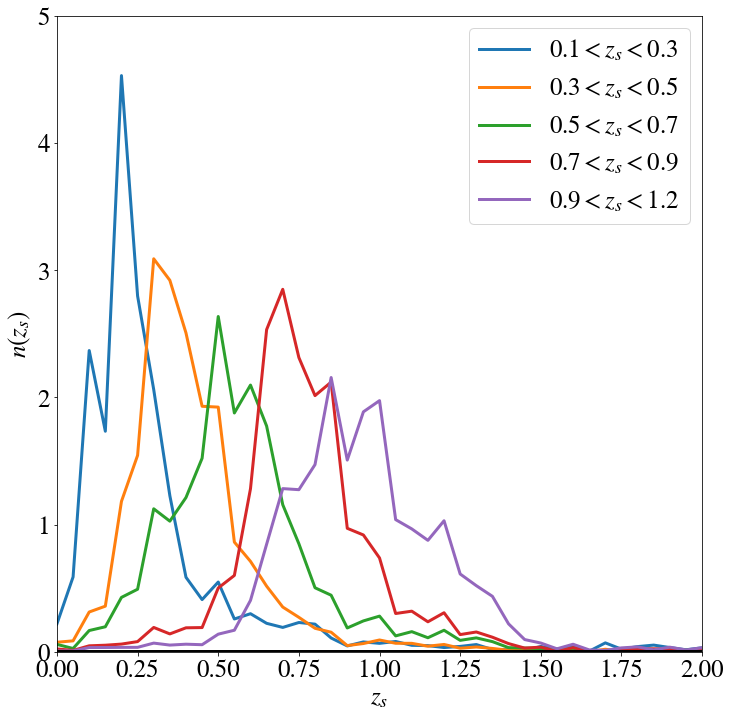

In [7]:
nz_source_plotter()

In [ ]:
cosmo = ccl.Cosmology(Omega_c=0.319-0.049, Omega_b=0.049, h=0.67, sigma8=0.83, n_s=0.96)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(gl[:,0], gl[:,1]))
clu1 = ccl.NumberCountsTracer(cosmo, dndz=(fl[:,0], fl[:,1]), has_rsd= False, bias = (fl[:,0] , 2.33956889*np.ones(len(fl[:,0]))))

In [17]:
def pred(bias, IA, dz, lens_bin, source_bin, lrg_type, lmin, lmax):
    
    if lrg_type == "lum":
        
        nzfile = h5py.File("nz_lum.h5", 'r')
        
    if lrg_type == "dense":
        
        nzfile = h5py.File("nzstack_dense.h5", 'r')
    
    zs = nzfile["z"][:]
    nzs = nzfile["nz"][:]
    
    
    
    nzfile.close()
        
    lens_nz = nzs[:, lens_bin] 
    lens_z = zs
    
    if source_bin == 0: 
        source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB01t03_blindB_Nz.asc")
    if source_bin == 1:
        source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB03t05_blindB_Nz.asc")
    if source_bin == 2:    
        source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB05t07_blindB_Nz.asc")
    if source_bin == 3:     
        source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB07t09_blindB_Nz.asc")
    if source_bin == 4:     
        source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB09t12_blindB_Nz.asc")  
        
    source_z = source_nzs[:,0]
    source_nz = source_nzs[:,1]
    
    cosmo = ccl.Cosmology(Omega_c=0.319 - 0.047, Omega_b=0.047, h=0.67, sigma8=0.831, n_s=0.96)
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(source_z, source_nz))
    clu1 = ccl.NumberCountsTracer(cosmo, dndz=(lens_z - dz, lens_nz), has_rsd= False, 
                                  bias = (lens_z , bias*np.ones(len(lens_z))))
    bias_ia = IA * np.ones(source_z.size) # Intrinsic alignment bias factor
    a_factor = 1/(1+source_z)
    D = ccl.growth_factor(cosmo, a_factor)
    rho_crit = ccl.RHO_CRITICAL
    omega_m = 0.319
    h = 0.67
    bias_ia = -1. * bias_ia * 5 * 10**-14. * rho_crit * omega_m * (h ** -2)/ D
    
    f_red = np.ones(source_z.size) # Fraction of red galaxies
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(source_z, source_nz), ia_bias=(source_z, bias_ia), red_frac=(source_z, f_red))
    
    theta_arcmin, xi, xierr, zlmin, zlmax, zsmin, zsmax, lrg_type = load_shear(lrg_type, lens_bin , source_bin)
    
    theta_deg = theta_arcmin/60.
    ell=np.arange(lmin, lmax)
    cl_gs = ccl.angular_cl(cosmo, clu1, lens1, ell)
    xi_gs = ccl.correlation(cosmo, ell, cl_gs, theta_deg, corr_type='GL', method='FFTLog')
    
    plt.plot(theta_arcmin, xi_gs)
    plt.errorbar(theta_arcmin, xi, yerr = xierr, fmt = "o")
    plt.xscale("log")
    plt.yscale("log")

    return xi_gs, xi, xierr

(array([4.55618293e-03, 3.51649005e-03, 3.06610205e-03, 2.04607692e-03,
        1.70994613e-03, 1.32842340e-03, 1.09505521e-03, 7.22229493e-04,
        5.71756587e-04, 4.59239796e-04, 3.90229270e-04, 3.01249150e-04,
        2.36421362e-04, 1.80106324e-04, 1.51512060e-04, 1.25834659e-04,
        1.06207236e-04, 9.04747024e-05, 7.49808436e-05, 6.18594548e-05]),
 array([3.52735947e-03, 3.37017939e-03, 1.84622044e-03, 1.37362147e-03,
        1.69584067e-03, 1.52268654e-03, 1.05673665e-03, 1.02569263e-03,
        6.02772006e-04, 5.84320677e-04, 4.87725639e-04, 2.11045057e-04,
        1.65759352e-04, 1.29144863e-04, 1.69554760e-04, 8.19282707e-05,
        7.49531206e-05, 3.89181520e-05, 6.52086065e-05, 5.75327347e-06]),
 array([1.04700695e-03, 7.28844171e-04, 8.67647686e-04, 8.54305712e-04,
        7.47954131e-04, 6.12147648e-04, 5.64480612e-04, 4.10086891e-04,
        4.18126948e-04, 3.23872788e-04, 2.45233964e-04, 2.14702450e-04,
        1.53174265e-04, 1.26072563e-04, 1.01949317e-04, 8.28

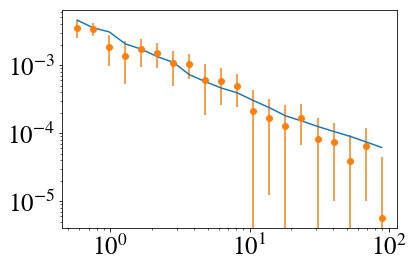

In [18]:
pred(bias=1.7, IA = 1, dz = 0.0, lens_bin=1, source_bin=2, lrg_type = "dense", lmin = 10, lmax = 1000)

In [19]:
cosmo = ccl.Cosmology(Omega_c=0.319 - 0.047, Omega_b=0.047, h=0.67, sigma8=0.831, n_s=0.96)

In [20]:
z = np.linspace(0.0001, 5., 100)
a = 1. / (1.+z)

In [21]:
D = ccl.growth_factor(cosmo, a)

In [22]:
ccl.RHO_CRITICAL

277536627245.7078

In [79]:
def pred_general(bias_pars, IA, dz, lrg_type, lmin, lmax):
    
    if lrg_type == "lum":
        
        nzfile = h5py.File("nz_lum.h5", 'r')
        
    if lrg_type == "dense":
        
        nzfile = h5py.File("nzstack_dense.h5", 'r')
    
    zs = nzfile["z"][:]
    nzs = nzfile["nz"][:]
        
    nzfile.close()
    
    theta_arcmin, xi, xierr, zlmin, zlmax, zsmin, zsmax, lrg_type = load_shear(lrg_type, 0 , 0)
    size = len(theta_arcmin) 
    predictions = np.zeros((4, 5, nzs.shape[1], size))

    for source_bin in range(5):
        if source_bin == 0: 
            source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB01t03_blindB_Nz.asc")
        if source_bin == 1:
            source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB03t05_blindB_Nz.asc")
        if source_bin == 2:    
            source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB05t07_blindB_Nz.asc")
        if source_bin == 3:     
            source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB07t09_blindB_Nz.asc")
        if source_bin == 4:     
            source_nzs = np.loadtxt("../../downloads/KiDS_2018-07-26_deepspecz_photoz_10th_BLIND_specweight_1000_4_ZB09t12_blindB_Nz.asc")  
        
        source_z = source_nzs[:,0]
        source_nz = source_nzs[:,1]
        for lens_bin in range(nzs.shape[1]):
            
            lens_nz = nzs[:, lens_bin] 
            lens_z = zs
            cosmo = ccl.Cosmology(Omega_c=0.319 - 0.047, Omega_b=0.047, h=0.67, sigma8=0.831, n_s=0.96)
            #lens1 = ccl.WeakLensingTracer(cosmo, dndz=(source_z, source_nz))
            clu1 = ccl.NumberCountsTracer(cosmo, dndz=(lens_z - dz, lens_nz), has_rsd= False, 
                                          bias = (lens_z , bias_pars[lens_bin]*np.ones(len(lens_z))))
            bias_ia = IA * np.ones(source_z.size) # Intrinsic alignment bias factor
            a_factor = 1/(1+source_z)
            D = ccl.growth_factor(cosmo, a_factor)
            rho_crit = ccl.RHO_CRITICAL
            omega_m = 0.319
            h = 1
            bias_ia = -1. * bias_ia * 5 * 10**-14. * rho_crit * omega_m * (h ** -2)/ D
    
            f_red = np.ones(source_z.size) # Fraction of red galaxies
            lens1 = ccl.WeakLensingTracer(cosmo, dndz=(source_z, source_nz), ia_bias=(source_z, bias_ia), red_frac=(source_z, f_red))
    
            theta_arcmin, xi, xierr, zlmin, zlmax, zsmin, zsmax, lrg_type = load_shear(lrg_type, lens_bin , source_bin)
    
            theta_deg = theta_arcmin/60.
            ell=np.arange(lmin, lmax)
            cl_gs = ccl.angular_cl(cosmo, clu1, lens1, ell)
            xi_gs = ccl.correlation(cosmo, ell, cl_gs, theta_deg, corr_type='GL', method='FFTLog')
            
            predictions[0, source_bin, lens_bin, :] = theta_arcmin
            predictions[1, source_bin, lens_bin, :] = xi
            predictions[2, source_bin, lens_bin, :] = xierr
            predictions[3, source_bin, lens_bin, :] = xi_gs

    return predictions

In [83]:
pred_lum = pred_general(bias_pars = [1.74, 1.838, 2.0547, 2.4975], IA = 0.9, dz=0, lrg_type="lum", lmin=10, lmax=1000)

In [84]:
def plot_lum():
    
    fig = plt.figure(1, figsize=(16,16))
    
    gs = gridspec.GridSpec(4,5)
    titx = [r"$0.1<z_s<0.3$", r"$0.3<z_s<0.5$", r"$0.5<z_s<0.7$", r"$0.7<z_s<0.9$", r"$0.9<z_s<1.2$"]
    tity = [r"$0.15<z_l<0.3$", r"$0.3<z_l<0.45$", r"$0.45<z_l<0.6$", r"$0.6<z_l<0.8$"]
    
    #pred_lum
    for i in range(4):
        for j in range(5):   
        
            ax = plt.subplot(gs[i,j])
    
            #print i
            r, xi, xierr, xi_gm = pred_lum[0, j, i, :], pred_lum[1, j, i, :], pred_lum[2, j, i, :], pred_lum[3, j, i, :]
            pos_mask = np.where(xi>0)[0]
            neg_mask = np.where(xi<0)[0]
            ax.errorbar(r[pos_mask] , xi[pos_mask] , yerr=xierr[pos_mask] , fmt="o", 
                        color='C'+str(j), markersize=5, lw=0, capsize=3, elinewidth=1.5)
            ax.errorbar(r[neg_mask]  , -1*xi[neg_mask], yerr=xierr[neg_mask], fmt="o", mfc='white', 
                        color='C'+str(j), markersize=5, 
                        lw=0, capsize=3, elinewidth=1.5)
            ax.plot(r, xi_gm, color = 'C'+str(j), linestyle = "dashed", linewidth = 2)
            
            if j == 0: 
                ax.set_ylabel(r'$\gamma_t \; (\theta)$')
            if i == 3: 
                ax.set_xlabel(r'$\theta \; [\mathrm{arcmin}]$')
 
            ax.set_xscale('log')
            ax.set_yscale('log')        
            ax.set_xlim([.2, 200.])
            ax.set_ylim([5e-6, .04])  
            if j != 0: 
                ax.set_yticklabels([])
                ax.set_yticks([]) 
            if i != 3:
                ax.set_xticklabels([]) 

            if i == 0:
                ax.set_title(titx[j])

            ax.yaxis.set_label_position("right")
            ax.set_ylabel(tity[i])   
                
    fig.subplots_adjust(wspace=0.0, hspace=0.0)  

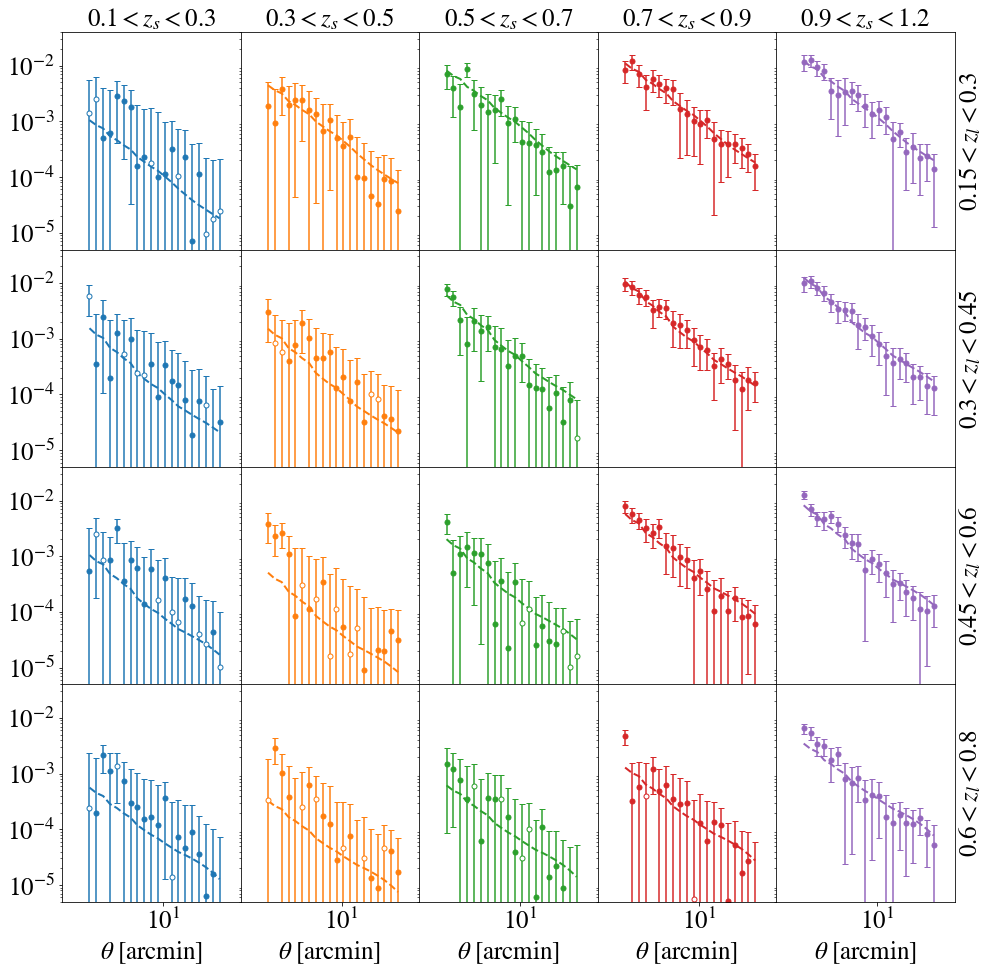

In [85]:
plot_lum()

In [86]:
pred_dense = pred_general(bias_pars = [1.521, 1.6518, 1.89989], IA = 0.9, dz=0, lrg_type="dense", lmin=10, lmax=1000)

In [89]:
def plot_dense():
    
    fig = plt.figure(1, figsize=(16,16))
    
    gs = gridspec.GridSpec(3,5)
    titx = [r"$0.1<z_s<0.3$", r"$0.3<z_s<0.5$", r"$0.5<z_s<0.7$", r"$0.7<z_s<0.9$", r"$0.9<z_s<1.2$"]
    tity = [r"$0.15<z_l<0.3$", r"$0.3<z_l<0.45$", r"$0.45<z_l<0.6$", r"$0.6<z_l<0.8$"]
    
    #pred_lum
    for i in range(3):
        for j in range(5):   
        
            ax = plt.subplot(gs[i,j])
    
            #print i
            r, xi, xierr, xi_gm = pred_dense[0, j, i, :], pred_dense[1, j, i, :], pred_dense[2, j, i, :], pred_dense[3, j, i, :]
            pos_mask = np.where(xi>0)[0]
            neg_mask = np.where(xi<0)[0]
            ax.errorbar(r[pos_mask] , xi[pos_mask] , yerr=xierr[pos_mask] , fmt="o", 
                        color='C'+str(j), markersize=5, lw=0, capsize=3, elinewidth=1.5)
            ax.errorbar(r[neg_mask]  , -1*xi[neg_mask], yerr=xierr[neg_mask], fmt="o", mfc='white', 
                        color='C'+str(j), markersize=5, 
                        lw=0, capsize=3, elinewidth=1.5)
            ax.plot(r, xi_gm, color = 'C'+str(j), linestyle = "dashed", linewidth = 2)
            
            if j == 0: 
                ax.set_ylabel(r'$\gamma_t \; (\theta)$')
            if i == 2: 
                ax.set_xlabel(r'$\theta \; [\mathrm{arcmin}]$')
 
            ax.set_xscale('log')
            ax.set_yscale('log')        
            ax.set_xlim([.2, 200.])
            ax.set_ylim([5e-6, .04])  
            if j != 0: 
                ax.set_yticklabels([])
                ax.set_yticks([]) 
            if i != 2:
                ax.set_xticklabels([]) 

            if i == 0:
                ax.set_title(titx[j])

            ax.yaxis.set_label_position("right")
            ax.set_ylabel(tity[i])   
                
    fig.subplots_adjust(wspace=0.0, hspace=0.0)  

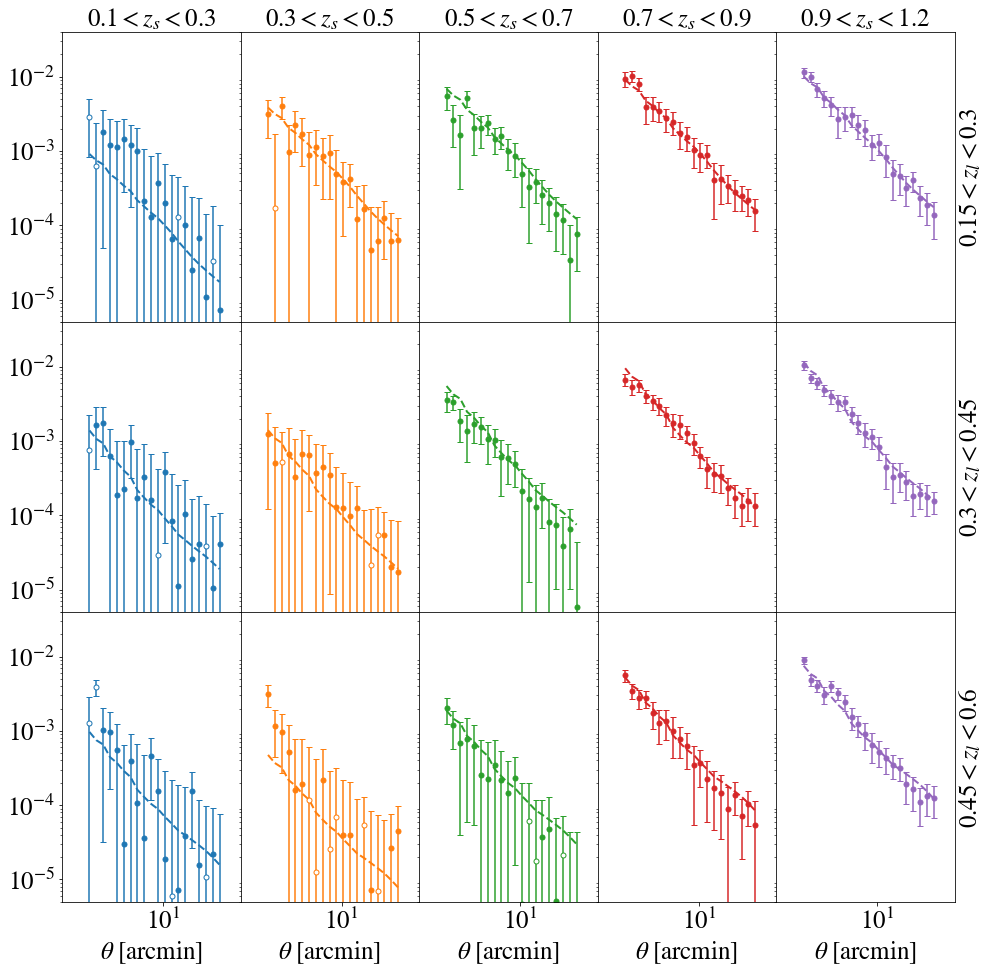

In [90]:
plot_dense()

In [22]:
x = h5py.File("../mask_dr4_new_v4.h5")

In [77]:
mag_mask = x['mag_gaap_r'][:]
mask = x['mask'][:]
sg_flag = x['SG_FLAG'][:]

In [26]:
np.nanmin(mag_mask)

13.489251

In [27]:
np.nanmax(mag_mask)

26.75397

In [56]:
sample = h5py.File("../lrg_dense_dr4.h5" , "r")
mask = sample['kids_mask'][:] == 0
print sample['mr'][mask][sample['zlrg'][mask]<0.6].max()
print sample['mr'][mask][sample['zlrg'][mask]<0.6].min()
print sample['kids_mask'][mask].shape
sample.close()


23.743471
16.409706
(459195,)


In [352]:
sample = h5py.File("../lrg_lum_dr4.h5" , "r")
mask = (sample['kids_mask'][:] == 0)&(sample['star_mask'][:] == 0)#&(np.isfinite(sample['mk'][:]) == True)
print sample['mr'][mask][sample['zlrg'][mask]<0.8].max()
print sample['mr'][mask][sample['zlrg'][mask]<0.8].min()
print sample['kids_mask'][mask].shape
sample.close()

24.063667
16.452843
(119205,)


In [39]:
sample = pf.open("/home/vakili/Downloads/photozs.DR4_trained-on-GAMAequ_ugri+KV_version0.9.fits")

In [42]:
mrb =  sample[1].data['MAG_GAAP_r']
print mrb.min()
print mrb.max()

13.5788965
21.099998


In [43]:
np.nanmedian(mag_mask)

23.940914

In [78]:
mask_g = (np.isfinite(mag_mask) == True)&(mask == 0)&(mag_mask > 16.4)&(mag_mask < 24.2)&(sg_flag == 1)

/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [79]:
mag_mask[mask_g].shape

(44102425,)

In [92]:
sample.update?

In [213]:
arr, keys = [], []
for k, v in sample.items():
    arr.append(sample[k][:][mask])
    keys.append(k)    

In [215]:
kws = copy(keys)
print kws = 

[u'DEC' u'ID' u'RA' u'chired' u'color_errs' u'colors' u'kids_mask'
 u'lratio' u'mg' u'mh' u'mi' u'mj' u'mk' u'mr' u'mr_auto' u'mu' u'my'
 u'mz' u'star_mask' u'tile' u'zlrg']


/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: invalid literal for int() with base 10: 'DEC'

In [205]:
keys

[u'ID',
 u'RA',
 u'chired',
 u'color_errs',
 u'colors',
 u'kids_mask',
 u'lratio',
 u'mg',
 u'mh',
 u'mi',
 u'mj',
 u'mk',
 u'mr',
 u'mr_auto',
 u'mu',
 u'my',
 u'mz',
 u'star_mask',
 u'tile',
 u'zlrg']

In [198]:
ra_col = np.where(np.array(keys) == 'RA')[0][0]
arr[ra_col]

array([1.77500000e-02, 3.71590000e-02, 4.17310000e-02, ...,
       3.59972382e+02, 3.59981395e+02, 3.59989286e+02])

In [114]:
keys.append("a")
keys.append("b")

In [166]:
x = [1, 3.4, -99, np.nan]
y = [1, -99, np.nan, 45]
z = [1,2,3,4]

In [174]:
arr = [x, y, z]
keys = {"x", "y", "z"}

In [168]:
mask = np.isfinite(x)&(np.array(x)>0)

/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [170]:
for c in arr[1:]:
    
    mask = mask&np.isfinite(c)&(np.array(c)>0)

/software/rhel7/lib64/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [171]:
mask

array([ True, False, False, False])

In [176]:
dic = {}

In [186]:
for k, v in itertools.product(keys, arr):
    print k
    print v

y
[1, 3.4, -99, nan]
y
[1, -99, nan, 45]
y
[1, 2, 3, 4]
x
[1, 3.4, -99, nan]
x
[1, -99, nan, 45]
x
[1, 2, 3, 4]
z
[1, 3.4, -99, nan]
z
[1, -99, nan, 45]
z
[1, 2, 3, 4]


In [182]:
import itertools

In [188]:
sample.items()

[(u'DEC', <HDF5 dataset "DEC": shape (141388,), type "<f8">),
 (u'ID', <HDF5 dataset "ID": shape (141388,), type "|S30">),
 (u'RA', <HDF5 dataset "RA": shape (141388,), type "<f8">),
 (u'chired', <HDF5 dataset "chired": shape (141388,), type "<f8">),
 (u'color_errs',
  <HDF5 dataset "color_errs": shape (141388, 4, 4), type "<f8">),
 (u'colors', <HDF5 dataset "colors": shape (141388, 4), type "<f4">),
 (u'kids_mask', <HDF5 dataset "kids_mask": shape (141388,), type "<i4">),
 (u'lratio', <HDF5 dataset "lratio": shape (141388,), type "<f8">),
 (u'mg', <HDF5 dataset "mg": shape (141388,), type "<f4">),
 (u'mh', <HDF5 dataset "mh": shape (141388,), type "<f4">),
 (u'mi', <HDF5 dataset "mi": shape (141388,), type "<f4">),
 (u'mj', <HDF5 dataset "mj": shape (141388,), type "<f4">),
 (u'mk', <HDF5 dataset "mk": shape (141388,), type "<f4">),
 (u'mr', <HDF5 dataset "mr": shape (141388,), type "<f4">),
 (u'mr_auto', <HDF5 dataset "mr_auto": shape (141388,), type "<f8">),
 (u'mu', <HDF5 dataset "

In [218]:
np.nanpercentile([1, 2, 23, 5, 6, np.nan], 2)

1.08

In [280]:
ida = np.random.randint(0, 10, 50)
idb = np.arange(100)
vb = np.random.rand(100)
print vb.shape

(100,)


In [263]:
vaa = ida.copy()

In [265]:
for k in range(len(ida)):
    ind = np.where(idb == ida[k])[0][0]
    #print ind, vb[ind]
    #print k
    vaa[k] = vb[ind]
    print vaa[k], vb[ind]


0 0.37070372631764026
0 0.6792355335996184
0 0.6792355335996184
0 0.07634770586013806
0 0.2778768187733971
0 0.9331344561789601
0 0.8243815024642598
0 0.9331344561789601
0 0.07634770586013806
0 0.5573323807681101
0 0.6944065040911565
0 0.8243815024642598
0 0.9331344561789601
0 0.5573323807681101
0 0.9331344561789601
0 0.345487429174118
0 0.37070372631764026
0 0.37070372631764026
0 0.6792355335996184
0 0.8243815024642598
0 0.2778768187733971
0 0.6944065040911565
0 0.2778768187733971
0 0.6792355335996184
0 0.8243815024642598
0 0.37070372631764026
0 0.9331344561789601
0 0.07634770586013806
0 0.6944065040911565
0 0.29481309571233316
0 0.37070372631764026
0 0.8243815024642598
0 0.37070372631764026
0 0.6792355335996184
0 0.8243815024642598
0 0.8243815024642598
0 0.345487429174118
0 0.2778768187733971
0 0.5573323807681101
0 0.6944065040911565
0 0.07634770586013806
0 0.345487429174118
0 0.345487429174118
0 0.8243815024642598
0 0.8243815024642598
0 0.5573323807681101
0 0.07634770586013806
0 0.2

In [266]:
import pandas as pd

In [277]:
ida, idb, vb
dfa = pd.DataFrame(vb, columns = idb)

ValueError: Shape of passed values is (2, 100), indices imply (100, 100)

In [295]:
arrb = { 'id': idb, 'vb':vb}
dfb = pd.DataFrame(arrb, columns= ['id', 'vb'])

,id,vb
0,0,0.234620
1,1,0.123227
2,2,0.167919
3,3,0.321802
4,4,0.263719
5,5,0.980088
6,6,0.608831
7,7,0.986320
8,8,0.454565
9,9,0.611472


In [297]:
arra = { 'id': ida, 'va':va}
dfa = pd.DataFrame(arra, columns= ['id', 'va'])

In [298]:
dfa

,id,va
0,5,0
1,4,0
2,3,0
3,2,0
4,2,0
5,7,0
6,2,0
7,6,0
8,1,0
9,2,0


In [299]:
df_merge_col = pd.merge(dfa, dfb, on='id')

In [301]:
pd.merge(dfb, dfa, on='id')

,id,vb,va
0,0,0.234620,0
1,0,0.234620,0
2,0,0.234620,0
3,0,0.234620,0
4,0,0.234620,0
5,1,0.123227,0
6,1,0.123227,0
7,1,0.123227,0
8,1,0.123227,0
9,1,0.123227,0


In [314]:
dic = {}
for k in df_merge_col.columns:
    dic[k] = df_merge_col[k].values

In [319]:
df_merge_col['id'].values

array([5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 9, 9, 9,
       9, 9, 8, 8, 8, 8])

In [320]:
mask = df_merge_col['vb'].values > 0.5

In [321]:
df_merge_col[mask]

,id,va,vb
0,5,0,0.980088
1,5,0,0.980088
17,7,0,0.986320
18,7,0,0.986320
19,7,0,0.986320
20,7,0,0.986320
21,6,0,0.608831
22,6,0,0.608831
23,6,0,0.608831
24,6,0,0.608831


In [338]:
len_cat = len(df_merge_col['id'].values)
print len_cat

50


In [349]:
random_index = np.random.choice(len_cat, size = int(0.5*len_cat), replace=False, p=None)
print random_index
np.in1d(np.arange(len_cat), random_index).shape

[40 24 16  4 45 21 15 19 38 34 27 48 12  8 20 23 36 46  0 26  6 32  5 22
 33]


(50,)

In [341]:
df_merge_col[random_index]

IndexError: indices are out-of-bounds

In [345]:
mask = df_merge_col['vb'].values > 0.5
print mask
df_merge_col[mask]

[ True  True False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False  True  True  True  True  True False False
 False False]


,id,va,vb
0,5,0,0.980088
1,5,0,0.980088
17,7,0,0.986320
18,7,0,0.986320
19,7,0,0.986320
20,7,0,0.986320
21,6,0,0.608831
22,6,0,0.608831
23,6,0,0.608831
24,6,0,0.608831


In [353]:
38642110 *1./ 44107116

0.876096954514097

In [354]:
x = h5py.File("xcross_sys_index_1.h5")

In [355]:
x.keys()

[u'som_cov', u'theta', u'uniform_cov', u'xi_som', u'xi_unif']

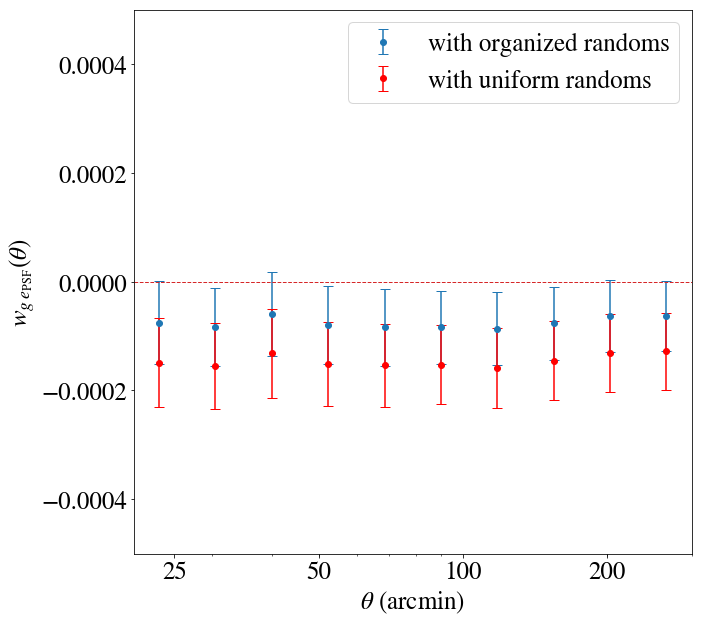

In [597]:
x = h5py.File("xcross_sys_index_1.h5")
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(x['theta'][:], x['xi_som'][:], np.diag(x['som_cov'][:])**.5, capsize= 5, fmt = 'o', label = 'with organized randoms')
ax.errorbar(x['theta'][:], x['xi_unif'][:], np.diag(x['uniform_cov'][:])**.5, capsize= 5, color = 'red', fmt = 'o', label = 'with uniform randoms')
ax.axhline(0, color = 'C3', linewidth = 1, linestyle = 'dashed')
ax.set_xscale('log')
ax.set_xticks([25, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel(r"$\theta$ (arcmin)")
ax.set_ylabel(r"$w_{g \; e_{\rm PSF}} (\theta)$")
ax.set_ylim([-5.*10**-4,  5.*10**-4])
plt.legend(fontsize = 25)

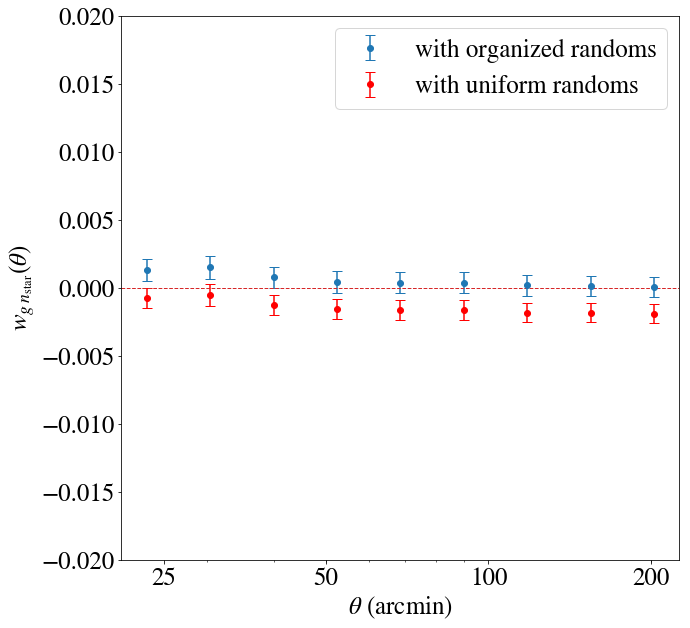

In [602]:
x.close()
x = h5py.File("xcross_sys_index_2.h5")
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(x['theta'][:-1], x['xi_som'][:-1], np.diag(x['som_cov'][:-1])**.5, capsize= 5, fmt = 'o', label = 'with organized randoms')
ax.errorbar(x['theta'][:-1], x['xi_unif'][:-1], np.diag(x['uniform_cov'][:-1])**.5, capsize= 5, color = 'red', fmt = 'o', label = 'with uniform randoms')
ax.axhline(0, color = 'C3', linewidth = 1, linestyle = 'dashed')
ax.set_xscale('log')
ax.set_xticks([25, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel(r"$\theta$ (arcmin)")
ax.set_ylabel(r"$w_{g \; n_{\rm star}} (\theta)$")
ax.set_ylim([-2.*10**-2,  2.*10**-2])
plt.legend(fontsize = 25)

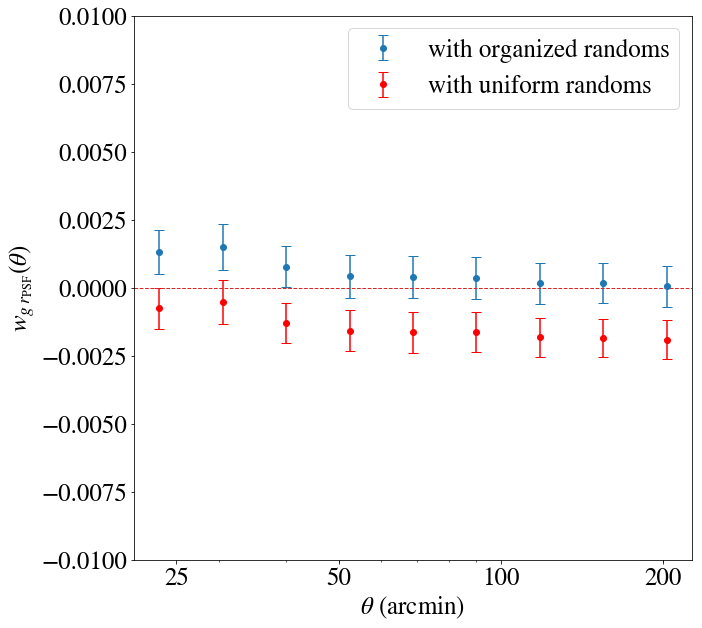

In [603]:
x = h5py.File("xcross_sys_index_2.h5")
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(x['theta'][:-1], x['xi_som'][:-1], np.diag(x['som_cov'][:-1])**.5, capsize= 5, fmt = 'o', label = 'with organized randoms')
ax.errorbar(x['theta'][:-1], x['xi_unif'][:-1], np.diag(x['uniform_cov'][:-1])**.5, capsize= 5, color = 'red', fmt = 'o', label = 'with uniform randoms')
ax.axhline(0, color = 'C3', linewidth = 1, linestyle = 'dashed')
ax.set_xscale('log')
ax.set_xticks([25, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel(r"$\theta$ (arcmin)")
ax.set_ylabel(r"$w_{g \; r_{\rm PSF}} (\theta)$")
ax.set_ylim([-1.*10**-2,  1.*10**-2])
plt.legend(fontsize = 25)

KeyError: "Unable to open object (object 'theta' doesn't exist)"

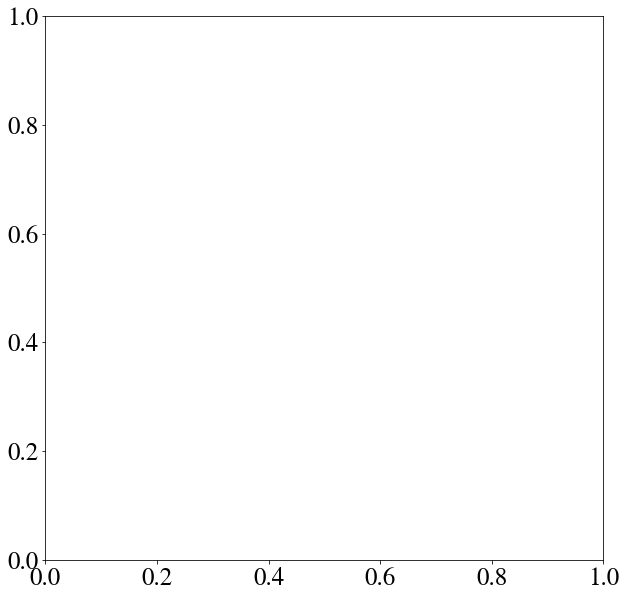

In [604]:
x = h5py.File("xcross_sys_index_3.h5")
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(x['theta'][:-1], x['xi_som'][:-1], np.diag(x['som_cov'][:-1])**.5, capsize= 5, fmt = 'o', label = 'with organized randoms')
ax.errorbar(x['theta'][:-1], x['xi_unif'][:-1], np.diag(x['uniform_cov'][:-1])**.5, capsize= 5, color = 'red', fmt = 'o', label = 'with uniform randoms')
ax.axhline(0, color = 'C3', linewidth = 1, linestyle = 'dashed')
ax.set_xscale('log')
ax.set_xticks([25, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel(r"$\theta$ (arcmin)")
ax.set_ylabel(r"$w_{g \; r_{\rm PSF}} (\theta)$")
ax.set_ylim([-1.*10**-2,  1.*10**-2])
plt.legend(fontsize = 25)

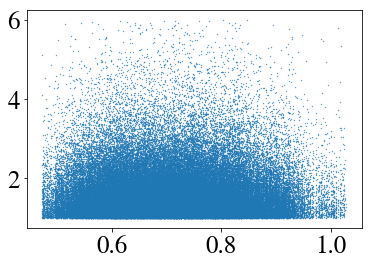

Index([u'Unnamed: 0', u'ALPHA_J2000', u'DELTA_J2000', u'fpixel', u'nstar',
       u'ell', u'fwhm', u'bkg', u'ext', u'mu', u'ulim', u'glim', u'rlim',
       u'ilim', u'zlim', u'ylim', u'jlim', u'hlim', u'klim', u'mr', u'lratio'],
      dtype='object')
[0.26475398 0.1425737  0.01383688 0.00423277 0.00327317]


Text(0.5,0,'n$_{\\rm star}$ (arcmin$^{-2}$)')

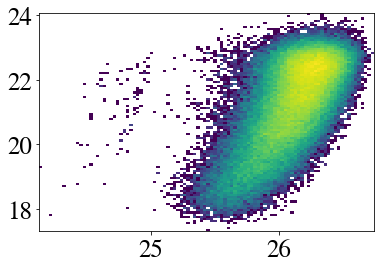

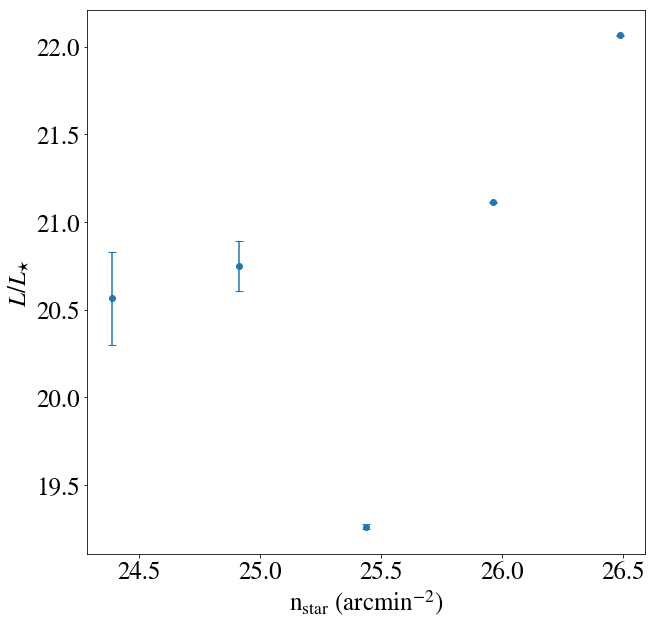

In [582]:
x = pd.read_csv("lrg_lum_zmin_0.15_zmax_0.8_set_test.csv")
print x.columns
lr, rlim= x['mr'], x['rlim']
plt.hist2d(rlim, lr, bins=100, norm = LogNorm())
#perc = np.percentile(rlim, [.5, 99.5])
#mask = (rlim>perc[0])&(rlim<perc[1])
#lr , rlim = lr[mask], rlim[mask]
bin_means, bin_edges, binnumber = stats.binned_statistic(rlim, lr, statistic='mean', bins=5)
bin_means_errs, bin_edges, binnumber = stats.binned_statistic(rlim, 
                                                               lr, 
                                                               statistic=stats.sem, 
                                                               bins=5)
print bin_means_errs    
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , bin_means_errs, fmt = "o", capsize = 4, label = "bias", color =  '#1F77B4')
ax.set_ylabel(r"$L/L_{\star}$")
ax.set_xlabel(r"n$_{\rm star}$ (arcmin$^{-2}$)")
#plt.save

[24.12978172 25.9967556  26.15570259 26.29271126 26.74614906]


/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/software/local/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


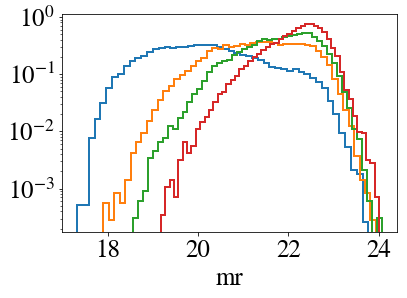

In [583]:
percs = np.percentile(rlim, [0,25,50,75,100])
print percs
for ind in range(len(percs)-1):
    #print ind
    mask = (rlim>percs[ind])&(rlim<percs[ind+1])
    sns.distplot(lr[mask], kde = False, norm_hist=True, hist_kws={"histtype": "step", "linewidth": 2,"alpha" : 1.0})
    plt.yscale("log")

In [590]:
j = lr.as_matrix()

In [595]:
j[j > np.percentile(j , 50)]

array([22.12368202, 21.90420341, 22.30441666, ..., 22.36874962,
       22.6937027 , 22.4449234 ])

In [605]:
import healpy as hp

In [606]:
hp.pixelfunc.nside2pixarea(nside = 256, degrees=True) * 60.**2.

188.84107017251253